# 深度强化学习－用卷积神经网络实现AI玩Flappy Bird游戏

本节课我们结合Flappy bird游戏，详细讲述了深度强化学习原理，以及如何训练一个神经网络来玩儿游戏

整个代码包括了利用PyGame包实现一个Flappy Bird游戏，卷积神经网络的定义与实现，以及深度强化学习算法。

本程序参考了AI玩Flappy Bird的TensorFlow版本：https://github.com/yenchenlin/DeepLearningFlappyBird

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第X课的配套源代码

## 一、PyGAME实现Flappy Bird游戏

在这部分中，我们调用PyGame包实现了一个Flappy Bird游戏。通过PyGame，我们可以非常方便的加载图片、音频，来快速实现小游戏

### 1. 加载游戏所需的必要资源

In [12]:
# 加载游戏中的所有资源，包括图片以及音频
# 调用PyGame包，关于该包的安装，请参看：http://www.pygame.org/wiki/GettingStarted
import pygame

# 需要获取操作系统类型，故而调用sys包
import sys
def load():
    # 加载各类资源的函数
    # 精灵在不同状态下的图片
    PLAYER_PATH = (
            'assets/sprites/redbird-upflap.png',
            'assets/sprites/redbird-midflap.png',
            'assets/sprites/redbird-downflap.png'
    )

    # 背景图地址
    BACKGROUND_PATH = 'assets/sprites/background-black.png'

    # 管道图片所在的地址
    PIPE_PATH = 'assets/sprites/pipe-green.png'

    IMAGES, SOUNDS, HITMASKS = {}, {}, {}

    # 加载成绩数字所需的图片
    IMAGES['numbers'] = (
        pygame.image.load('assets/sprites/0.png').convert_alpha(),
        pygame.image.load('assets/sprites/1.png').convert_alpha(),
        pygame.image.load('assets/sprites/2.png').convert_alpha(),
        pygame.image.load('assets/sprites/3.png').convert_alpha(),
        pygame.image.load('assets/sprites/4.png').convert_alpha(),
        pygame.image.load('assets/sprites/5.png').convert_alpha(),
        pygame.image.load('assets/sprites/6.png').convert_alpha(),
        pygame.image.load('assets/sprites/7.png').convert_alpha(),
        pygame.image.load('assets/sprites/8.png').convert_alpha(),
        pygame.image.load('assets/sprites/9.png').convert_alpha()
    )

    # 加载地面的图片
    IMAGES['base'] = pygame.image.load('assets/sprites/base.png').convert_alpha()

    # 加载声音文件（在不同的系统中，声音文件扩展名不同）
    if 'win' in sys.platform:
        soundExt = '.wav'
    else:
        soundExt = '.ogg'

    SOUNDS['die']    = pygame.mixer.Sound('assets/audio/die' + soundExt)
    SOUNDS['hit']    = pygame.mixer.Sound('assets/audio/hit' + soundExt)
    SOUNDS['point']  = pygame.mixer.Sound('assets/audio/point' + soundExt)
    SOUNDS['swoosh'] = pygame.mixer.Sound('assets/audio/swoosh' + soundExt)
    SOUNDS['wing']   = pygame.mixer.Sound('assets/audio/wing' + soundExt)

    # 加载背景图
    IMAGES['background'] = pygame.image.load(BACKGROUND_PATH).convert()

    # s加载精灵图
    IMAGES['player'] = (
        pygame.image.load(PLAYER_PATH[0]).convert_alpha(),
        pygame.image.load(PLAYER_PATH[1]).convert_alpha(),
        pygame.image.load(PLAYER_PATH[2]).convert_alpha(),
    )

    # 加载水管
    IMAGES['pipe'] = (
        pygame.transform.rotate(
            pygame.image.load(PIPE_PATH).convert_alpha(), 180),
        pygame.image.load(PIPE_PATH).convert_alpha(),
    )

    # 获得水管的蒙板
    HITMASKS['pipe'] = (
        getHitmask(IMAGES['pipe'][0]),
        getHitmask(IMAGES['pipe'][1]),
    )

    # 玩家的蒙板
    HITMASKS['player'] = (
        getHitmask(IMAGES['player'][0]),
        getHitmask(IMAGES['player'][1]),
        getHitmask(IMAGES['player'][2]),
    )

    #返回了三个字典，每个字典的值分别存储图像、声音和蒙板
    return IMAGES, SOUNDS, HITMASKS

def getHitmask(image):
    """根据图像的alpha，获得蒙板"""
    #所谓蒙板就是指将图像中的主体从整个图像中抠出来的技术，从而方便与其它的对象合成到一起
    #蒙板用一个boolean类型的列表来存储
    mask = []
    for x in range(image.get_width()):
        mask.append([])
        for y in range(image.get_height()):
            mask[x].append(bool(image.get_at((x,y))[3]))
    return mask

### 2. 实现Flappy Bird的游戏逻辑

In [13]:
# 加载程序所需的包
import numpy as np
import sys
import random
import pygame
import pygame.surfarray as surfarray
from pygame.locals import *
from itertools import cycle

FPS = 30 #帧率
SCREENWIDTH  = 288 #屏幕的宽度
SCREENHEIGHT = 512 #屏幕的高度

pygame.init() #游戏初始化
FPSCLOCK = pygame.time.Clock() #定义程序时钟
SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT)) #定义屏幕对象
pygame.display.set_caption('Flappy Bird') #设定窗口名称

IMAGES, SOUNDS, HITMASKS = load() #加载游戏资源
PIPEGAPSIZE = 100 # 定义两个水管之间的宽度
BASEY = SCREENHEIGHT * 0.79 #设定基地的高度

# 设定小鸟属性：宽度、高度等
PLAYER_WIDTH = IMAGES['player'][0].get_width()
PLAYER_HEIGHT = IMAGES['player'][0].get_height()

# 设定水管属性：高度、宽度
PIPE_WIDTH = IMAGES['pipe'][0].get_width()
PIPE_HEIGHT = IMAGES['pipe'][0].get_height()

#背景宽度
BACKGROUND_WIDTH = IMAGES['background'].get_width()

PLAYER_INDEX_GEN = cycle([0, 1, 2, 1])

# 游戏模型类
class GameState:
    def __init__(self):
        # 初始化
        # 初始成绩、玩家索引、循环迭代都为0
        self.score = self.playerIndex = self.loopIter = 0
        
        #设定玩家的初始位置
        self.playerx = int(SCREENWIDTH * 0.2)
        self.playery = int((SCREENHEIGHT - PLAYER_HEIGHT) / 2)
        self.basex = 0
        # 地面的初始移位
        self.baseShift = IMAGES['base'].get_width() - BACKGROUND_WIDTH

        # 生成两个随机的水管
        newPipe1 = getRandomPipe()
        newPipe2 = getRandomPipe()
        
        # 设定初始水管的位置x，y坐标
        self.upperPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[0]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[0]['y']},
        ]
        self.lowerPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[1]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[1]['y']},
        ]

        # 定义玩家的属性
        self.pipeVelX = -4
        self.playerVelY    =  0    # 小鸟在y轴上的速度，初始设置维playerFlapped
        self.playerMaxVelY =  10   # Y轴上的最大速度, 也就是最大的下降速度
        self.playerMinVelY =  -8   # Y轴向上的最大速度
        self.playerAccY    =   1   # 小鸟往下落的加速度
        self.playerFlapAcc =  -9   # 扇动翅膀的加速度
        self.playerFlapped = False # 玩家是否煽动了翅膀

    def frame_step(self, input_actions):
        # input_actions是一个行动数组，分别存储了0或者1两个动作的激活情况
        # 游戏每一帧的循环
        pygame.event.pump()

        # 每一步的默认回报
        reward = 0.1
        terminal = False

        # 限定每一帧只能做一个动作
        if sum(input_actions) != 1:
            raise ValueError('Multiple input actions!')

        # input_actions[0] == 1: 对应什么都不做
        # input_actions[1] == 1: 对应小鸟煽动了翅膀
        if input_actions[1] == 1:
            # 小鸟煽动翅膀向上
            if self.playery > -2 * PLAYER_HEIGHT:
                self.playerVelY = self.playerFlapAcc
                self.playerFlapped = True
                #SOUNDS['wing'].play()

        # 检查是否通过了管道，如果通过，则增加成绩
        playerMidPos = self.playerx + PLAYER_WIDTH / 2
        for pipe in self.upperPipes:
            pipeMidPos = pipe['x'] + PIPE_WIDTH / 2
            if pipeMidPos <= playerMidPos < pipeMidPos + 4:
                self.score += 1
                #SOUNDS['point'].play()
                reward = 1

        # playerIndex轮换
        if (self.loopIter + 1) % 3 == 0:
            self.playerIndex = next(PLAYER_INDEX_GEN)
        self.loopIter = (self.loopIter + 1) % 30
        self.basex = -((-self.basex + 100) % self.baseShift)

        # 小鸟运动
        if self.playerVelY < self.playerMaxVelY and not self.playerFlapped:
            self.playerVelY += self.playerAccY
        if self.playerFlapped:
            self.playerFlapped = False
        self.playery += min(self.playerVelY, BASEY - self.playery - PLAYER_HEIGHT)
        if self.playery < 0:
            self.playery = 0

        # 管道的移动
        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            uPipe['x'] += self.pipeVelX
            lPipe['x'] += self.pipeVelX

        # 当管道快到左侧边缘的时候，产生新的管道
        if 0 < self.upperPipes[0]['x'] < 5:
            newPipe = getRandomPipe()
            self.upperPipes.append(newPipe[0])
            self.lowerPipes.append(newPipe[1])

        # 当第一个管道移出屏幕的时候，就把它删除
        if self.upperPipes[0]['x'] < -PIPE_WIDTH:
            self.upperPipes.pop(0)
            self.lowerPipes.pop(0)

        # 检查碰撞
        isCrash= checkCrash({'x': self.playerx, 'y': self.playery,
                             'index': self.playerIndex},
                            self.upperPipes, self.lowerPipes)
        # 如果有碰撞发生，则游戏结束，terminal＝True
        if isCrash:
            #SOUNDS['hit'].play()
            #SOUNDS['die'].play()
            terminal = True
            self.__init__()
            reward = -1

        # 将所有角色都根据每个角色的坐标画到屏幕上
        SCREEN.blit(IMAGES['background'], (0,0))

        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            SCREEN.blit(IMAGES['pipe'][0], (uPipe['x'], uPipe['y']))
            SCREEN.blit(IMAGES['pipe'][1], (lPipe['x'], lPipe['y']))

        SCREEN.blit(IMAGES['base'], (self.basex, BASEY))
        
        # print score so player overlaps the score
        # showScore(self.score)
        SCREEN.blit(IMAGES['player'][self.playerIndex],
                    (self.playerx, self.playery))

        # 将当前的游戏屏幕生成一个二维画面返回
        image_data = pygame.surfarray.array3d(pygame.display.get_surface())
        pygame.display.update()
        FPSCLOCK.tick(FPS)
        #print self.upperPipes[0]['y'] + PIPE_HEIGHT - int(BASEY * 0.2)
        # 该函数的输出有三个变量：游戏当前帧的游戏画面，当前获得的游戏得分，游戏是否已经结束
        return image_data, reward, terminal
    

def getRandomPipe():
    #随机生成管道的函数
    """returns a randomly generated pipe"""
    # 两个管道之间的竖直间隔从下列数中直接取
    gapYs = [20, 30, 40, 50, 60, 70, 80, 90]
    index = random.randint(0, len(gapYs)-1)
    gapY = gapYs[index]

    #设定新生成管道的位置
    gapY += int(BASEY * 0.2)
    pipeX = SCREENWIDTH + 10

    # 返回管道的坐标
    return [
        {'x': pipeX, 'y': gapY - PIPE_HEIGHT},  # upper pipe
        {'x': pipeX, 'y': gapY + PIPEGAPSIZE},  # lower pipe
    ]


def showScore(score):
    # 在屏幕上直接展示成绩的函数
    """displays score in center of screen"""
    scoreDigits = [int(x) for x in list(str(score))]
    totalWidth = 0 # total width of all numbers to be printed

    for digit in scoreDigits:
        totalWidth += IMAGES['numbers'][digit].get_width()

    Xoffset = (SCREENWIDTH - totalWidth) / 2

    for digit in scoreDigits:
        SCREEN.blit(IMAGES['numbers'][digit], (Xoffset, SCREENHEIGHT * 0.1))
        Xoffset += IMAGES['numbers'][digit].get_width()


def checkCrash(player, upperPipes, lowerPipes):
    # 检测碰撞的函数，基本思路为：将每一个物体都看作是一个矩形区域，然后检查两个矩形区域是否有碰撞
    # 检查碰撞是细到每个对象的图像蒙板级别，而不单纯是看矩形之间的碰撞
    """returns True if player collders with base or pipes."""
    pi = player['index']
    player['w'] = IMAGES['player'][0].get_width()
    player['h'] = IMAGES['player'][0].get_height()

    # 检查小鸟是否碰撞到了地面
    if player['y'] + player['h'] >= BASEY - 1:
        return True
    else:
        # 检查小鸟是否与管道碰撞
        playerRect = pygame.Rect(player['x'], player['y'],
                      player['w'], player['h'])

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            # 上下管道矩形
            uPipeRect = pygame.Rect(uPipe['x'], uPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)
            lPipeRect = pygame.Rect(lPipe['x'], lPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)

            # 获得每个元素的蒙板
            pHitMask = HITMASKS['player'][pi]
            uHitmask = HITMASKS['pipe'][0]
            lHitmask = HITMASKS['pipe'][1]

            # 检查是否与上下管道相撞
            uCollide = pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
            lCollide = pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

            if uCollide or lCollide:
                return True

    return False

def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """在像素级别检查两个物体是否发生碰撞"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    # 确定矩形框，并针对矩形框中的每个像素进行循环，查看两个对象是否碰撞
    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in range(rect.width):
        for y in range(rect.height):
            if hitmask1[x1+x][y1+y] and hitmask2[x2+x][y2+y]:
                return True
    return False

### 3. 对游戏做小测试

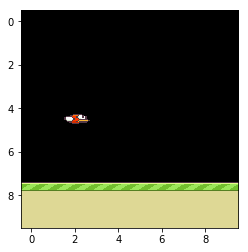

In [24]:

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# 新建一个游戏
game = GameState()

fig = plt.figure()
axe = fig.add_subplot(111)
dat = np.zeros((10, 10))
img = axe.imshow(dat)

# 进行100步循环，并将每一帧的画面打印出来
for i in range(100):
    clear_output(wait = True)
    image_data, reward, terminal = game.frame_step([0,1])
    
    image = np.transpose(image_data, (1, 0, 2))
    img.set_data(image)
    img.autoscale()
    display(fig)

## 二、训练神经网络玩游戏

### 1. 定义网络

In [15]:

#  导入必需的包
from __future__ import print_function

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import cv2 #需要安装OpenCV的包
import sys
sys.path.append("game/")
import random
import numpy as np
from collections import deque


# 定义一系列常数，其中，epsilon为每周期随机输出一个动作的概率
GAME = 'bird' # 游戏名称
ACTIONS = 2 # 有效输出动作的个数
GAMMA = 0.99 # 强化学习中未来的衰减率
OBSERVE = 10000. # 训练之前的时间步，需要先观察10000帧
EXPLORE = 3000000. # 退火所需的时间步，所谓的退火就是指随机选择率epsilon逐渐变小
FINAL_EPSILON = 0.0001 # epsilon的最终值
INITIAL_EPSILON = 0.1 # epsilon的初始值
REPLAY_MEMORY = 50000 # 最多记忆多少帧训练数据
BATCH = 32 # 每一个批次的数据记录条数
FRAME_PER_ACTION = 1 # 每间隔多少时间完成一次有效动作的输出

In [16]:

# 创建一个多层CNN网络，该网络接收的输入为4帧画面，输出为每个可能动作对应的Q函数值
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 第一层卷积，从4通道到32通道，窗口大小8，跳跃间隔4，填空白2
        self.conv1 = nn.Conv2d(4, 32, 8, 4, padding = 2)
        # Pooling层，窗口2*2
        self.pool = nn.MaxPool2d(2, 2)
        # 第二层卷积，从32通道到64通道，窗口大小4，跳跃间隔2，填空白1
        self.conv2 = nn.Conv2d(32, 64, 4, 2, padding = 1)
        # 第二个Pooling层，窗口2＊2，空白1
        #self.pool2 = nn.MaxPool2d(2, 2, padding = 1)
        # 第三层卷积层，输入输出通道都是64，填空白为1
        self.conv3 = nn.Conv2d(64, 64, 3, 1, padding = 1)
        
        # 最后有两层全链接层
        self.fc_sz = 1600
        self.fc1 = nn.Linear(self.fc_sz, 256)
        self.fc2 = nn.Linear(256, ACTIONS)

    def forward(self, x):
        # 输入为一个batch的数据，每一个为前后相连的4张图像，每个图像为80*80的大小
        # x的尺寸为：batch_size, 4, 80, 80
        x = self.conv1(x)
        # x的尺寸为：batch_size, 32, 20, 20
        x = F.relu(x)
        x = self.pool(x)
        # x的尺寸为：batch_size, 32, 10, 10
        x = F.relu(self.conv2(x))
        # x的尺寸为：batch_size, 64, 5, 5
        #x = self.pool2(x)
        x = F.relu(self.conv3(x))
        # x的尺寸为：batch_size, 64, 5, 5
        #x = self.pool2(x)
        # 将x设为1600维的向量, batch_size, 1600
        x = x.view(-1, self.fc_sz)
        x = F.relu(self.fc1(x))
        readout = self.fc2(x)
        return readout, x
    def init(self):
        # 初始化所有的网络权重
        self.conv1.weight.data =  torch.abs(0.01 * torch.randn(self.conv1.weight.size()))
        self.conv2.weight.data =  torch.abs(0.01 * torch.randn(self.conv2.weight.size()))
        self.conv3.weight.data =  torch.abs(0.01 * torch.randn(self.conv3.weight.size()))
        self.fc1.weight.data = torch.abs(0.01 * torch.randn(self.fc1.weight.size()))
        self.fc2.weight.data = torch.abs(0.01 * torch.randn(self.fc2.weight.size()))
        self.conv1.bias.data = torch.ones(self.conv1.bias.size()) * 0.01
        self.conv2.bias.data = torch.ones(self.conv2.bias.size()) * 0.01
        self.conv3.bias.data = torch.ones(self.conv3.bias.size()) * 0.01
        self.fc1.bias.data = torch.ones(self.fc1.bias.size()) * 0.01
        self.fc2.bias.data = torch.ones(self.fc2.bias.size()) * 0.01

In [7]:
# 开始在内存／GPU上定义一个网络
use_cuda = torch.cuda.is_available() #检测本台机器中是否有GPU

# 创建一个神经网络
net = Net()
# 初始化网络权重。之所以自定义初始化过程是为了增加神经网络权重的多样性
net.init()
# 如果有GPU，就把神经网络全部搬到GPU内存中做运算
net = net.cuda() if use_cuda else net

# 定义损失函数为MSE
criterion = nn.MSELoss().cuda() if use_cuda else nn.MSELoss()
# 定义优化器，并设置初始学习率维10^-6
optimizer = torch.optim.Adam(net.parameters(), lr=1e-6 )

# 开启一个游戏进程，开始与游戏引擎通话
game_state = GameState()

# 学习样本的存储区域deque是一个类似于list的存储容器
D = deque()

# 状态打印log记录位置
#a_file = open("logs_" + GAME + "/readout.txt", 'w')
#h_file = open("logs_" + GAME + "/hidden.txt", 'w')

# 将游戏设置为初始状态，并获得一个80*80的游戏湖面
do_nothing = np.zeros(ACTIONS)
do_nothing[0] = 1
x_t, r_0, terminal = game_state.frame_step(do_nothing)
x_t = cv2.cvtColor(cv2.resize(x_t, (80, 80)), cv2.COLOR_BGR2GRAY)
ret, x_t = cv2.threshold(x_t,1,255,cv2.THRESH_BINARY)

# 将初始的游戏画面叠加成4张作为神经网络的初始输入状态s_t
s_t = np.stack((x_t, x_t, x_t, x_t), axis=0)

# 设置初始的epsilon（采取随机行动的概率），并准备训练
epsilon = INITIAL_EPSILON
t = 0

### 2. 边做边学的核心算法

该算法分为三个阶段：

1、按照Epsilon贪婪算法采取一次行动；
2、将选择好的行动输入给游戏引擎，得到下一帧的状态，并生成本帧的训练数据
3、开始训练：

In [ ]:
# 记录每轮平均得分的容器
scores = []
all_turn_scores = []
while "flappy bird" != "angry bird":
    # 开始游戏循环
    ######################################################
    ##########首先，按照贪婪策略选择一个行动 ##################
    s = torch.from_numpy(s_t).type(torch.FloatTensor).requires_grad_(False)
    s = s.cuda() if use_cuda else s
    s = s.view(-1, s.size()[0], s.size()[1], s.size()[2])
    # 获取当前时刻的游戏画面，输入到神经网络中
    readout, h_fc1 = net(s)
    # 神经网络产生的输出为readout：选择每一个行动的预期Q值
    readout = readout.cpu() if use_cuda else readout
    # readout为一个二维向量，分别对应每一个动作的预期Q值
    readout_t = readout.data.numpy()[0]

    # 按照epsilon贪婪策略产生小鸟的行动，即以epsilon的概率随机输出行动或者以
    # 1-epsilon的概率按照预期输出最大的Q值给出行动
    a_t = np.zeros([ACTIONS])
    action_index = 0
    if t % FRAME_PER_ACTION == 0:
        # 如果当前帧可以行动，则
        if random.random() <= epsilon:
            # 产生随机行动
            #print("----------Random Action----------")
            action_index = random.randrange(ACTIONS)
        else:
            # 选择神经网络判断的预期Q最大的行动
            action_index = np.argmax(readout_t)
        a_t[action_index] = 1
    else:
        a_t[0] = 1 # do nothing

    # 模拟退火：让epsilon开始降低
    if epsilon > FINAL_EPSILON and t > OBSERVE:
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

    ######################################################################### 
    ##########其次，将选择好的行动输入给游戏引擎，并得到下一帧的状态 ################### 
    x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
    # 返回的x_t1_colored为游戏画面，r_t为本轮的得分，terminal为游戏在本轮是否已经结束
    
    # 记录一下每一步的成绩
    scores.append(r_t)
    if terminal:
        # 当游戏结束的时候，计算一下本轮的总成绩，并将总成绩存储到all_turn_scores中
        all_turn_scores.append(sum(scores))
        scores = []
    
    # 对游戏的原始画面做相应的处理，从而变成一张80*80的，朴素的（无背景画面）的图
    x_t1 = cv2.cvtColor(cv2.resize(x_t1_colored, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, x_t1 = cv2.threshold(x_t1, 1, 255, cv2.THRESH_BINARY)
    x_t1 = np.reshape(x_t1, (1, 80, 80))
    # 将当前帧的画面和前三帧的画面合并起来作为Agent获得的环境反馈结果
    s_t1 = np.append(x_t1, s_t[:3, :, :], axis=0)
    # 生成一个训练数据，分别将本帧的输入画面s_t,本帧的行动a_t，得到的环境回报r_t以及环境被转换的新状态s_t1存到D中
    D.append((s_t, a_t, r_t, s_t1, terminal))
    if len(D) > REPLAY_MEMORY:
        # 如果D中的元素已满，则扔掉最老的一条训练数据
        D.popleft()

    ######################################################################### 
    ##########最后，当运行周期超过一定次数后开始训练神经网络 ################### 
    if t > OBSERVE:
        # 从D中随机采样出一个batch的训练数据
        minibatch = random.sample(D, BATCH)
        optimizer.zero_grad()

        # 将这个batch中的s变量都分别存放到列表中
        s_j_batch = [d[0] for d in minibatch]
        a_batch = [d[1] for d in minibatch]
        r_batch = [d[2] for d in minibatch]
        s_j1_batch = [d[3] for d in minibatch]

        # 接下来，要根据s_j1_batch，神经网络给出预估的未来Q值
        
        s = torch.tensor(np.array(s_j1_batch, dtype=float), dtype = torch.float, requires_grad = True)
        s = s.cuda() if use_cuda else s
        readout, h_fc1 = net(s)
        readout = readout.cpu() if use_cuda else readout
        readout_j1_batch = readout.data.numpy()
        # readout_j1_batch存储了一个minibatch中的所有未来一步的Q预估值
        # 根据Q的预估值，当前的反馈r，以及游戏是否结束，更新待训练的目标函数值
        y_batch = []
        for i in range(0, len(minibatch)):
            terminal = minibatch[i][4]
            # 当游戏结束的时候，则用环境的反馈作为目标，否则用下一状态的Q值＋本期的环境反馈
            if terminal:
                y_batch.append(r_batch[i])
            else:
                y_batch.append(r_batch[i] + GAMMA * np.max(readout_j1_batch[i]))

        # 开始梯度更新
        y = torch.tensor(y_batch, dtype = torch.float)
        a = torch.tensor(a_batch, dtype = torch.float)
        s = torch.tensor(np.array(s_j_batch, dtype=float), dtype = torch.float)
        if use_cuda:
            y = y.cuda()
            a = a.cuda()
            s = s.cuda()
        # 计算s_j_batch的Q值
        readout, h_fc1 = net(s)
        readout_action = readout.mul(a).sum(1)
        # 根据s_j_batch下所选择的预估Q和目标y的Q值的差来作为损失函数训练网络
        loss = criterion(readout_action, y)
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            print('损失函数：', loss)
       

    # 将状态更新一次，时间步＋1
    s_t = s_t1
    t += 1

    # 每隔 10000 次循环，存储一下网络
    if t % 10000 == 0:
        torch.save(net, 'saving_nets/' + GAME + '-dqn' + str(t) + '.txt')
    
    # 状态信息的转化，基本分为Observe，explore和train三个阶段
    # Observe没有训练，explore开始训练，并且开始模拟退火，train模拟退火结束
    state = ""
    if t <= OBSERVE:
        state = "observe"
    elif t > OBSERVE and t <= OBSERVE + EXPLORE:
        state = "explore"
    else:
        state = "train"
        
    # 打印当前运行的一些基本数据，分别输出到屏幕以及log文件中
    if t % 1000 == 0:
        sss = "时间步 {}/ 状态 {}/ Epsilon {:.2f}/ 行动 {}/ 奖励 {}/ Q_MAX {:e}/ 轮得分 {:.2f}".format(
            t, state, epsilon, action_index, r_t, np.max(readout_t), np.mean(all_turn_scores[-1000:]))
        print(sss)
        f = open('log_file.txt', 'a')
        f.write(sss + '\n')
        f.close()
    # write info to files
    

时间步 1000/ 状态 observe/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 3.789328e+04/ 轮得分 1.38
时间步 2000/ 状态 observe/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 4.960289e+04/ 轮得分 1.43
时间步 3000/ 状态 observe/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 3.579410e+04/ 轮得分 1.38
时间步 4000/ 状态 observe/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 4.554549e+04/ 轮得分 1.37
时间步 5000/ 状态 observe/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 4.300679e+04/ 轮得分 1.35
时间步 6000/ 状态 observe/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 3.880158e+04/ 轮得分 1.38
时间步 7000/ 状态 observe/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 3.622109e+04/ 轮得分 1.34
时间步 8000/ 状态 observe/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 3.716134e+04/ 轮得分 1.33
时间步 9000/ 状态 observe/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 6.387247e+04/ 轮得分 1.30


/home/jake/anaconda/envs/learning_pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


时间步 10000/ 状态 observe/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 3.724834e+04/ 轮得分 1.29
时间步 11000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 4.786650e+04/ 轮得分 1.35
损失函数： Variable containing:
 1.0755e+08
[torch.FloatTensor of size 1]

时间步 12000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 4.243400e+04/ 轮得分 1.46
损失函数： Variable containing:
 6.7522e+07
[torch.FloatTensor of size 1]

时间步 13000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 3.779126e+04/ 轮得分 1.56
损失函数： Variable containing:
 3.6268e+07
[torch.FloatTensor of size 1]

时间步 14000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 3.144210e+04/ 轮得分 1.65
损失函数： Variable containing:
 1.9996e+07
[torch.FloatTensor of size 1]

时间步 15000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 2.603308e+04/ 轮得分 1.74
损失函数： Variable containing:
 1.3511e+07
[torch.FloatTensor of size 1]

时间步 16000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 2.198958e+04/ 轮得分 1.82
损失函数： Variable containing:
 1.3862e+06
[torch.FloatTensor of size 1]

时间步 17000/ 状态 explor

损失函数： Variable containing:
 29.7879
[torch.FloatTensor of size 1]

时间步 66000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 6.003176e+01/ 轮得分 3.84
损失函数： Variable containing:
 16.9496
[torch.FloatTensor of size 1]

时间步 67000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 4.286507e+01/ 轮得分 3.84
损失函数： Variable containing:
 21.4764
[torch.FloatTensor of size 1]

时间步 68000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 3.743182e+01/ 轮得分 3.84
损失函数： Variable containing:
 2.0106
[torch.FloatTensor of size 1]

时间步 69000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 2.269907e+00/ 轮得分 3.84
损失函数： Variable containing:
 2.1155
[torch.FloatTensor of size 1]

时间步 70000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 4.312591e+01/ 轮得分 3.85
损失函数： Variable containing:
 5.7124
[torch.FloatTensor of size 1]

时间步 71000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX -4.687382e+00/ 轮得分 3.85
损失函数： Variable containing:
 1.4033
[torch.FloatTensor of size 1]

时间步 72000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_M

时间步 118000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.970870e+00/ 轮得分 4.36
损失函数： Variable containing:
1.00000e-03 *
  4.0209
[torch.FloatTensor of size 1]

时间步 119000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.609194e+00/ 轮得分 4.37
损失函数： Variable containing:
1.00000e-02 *
  3.2891
[torch.FloatTensor of size 1]

时间步 120000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 6.224102e-01/ 轮得分 4.37
损失函数： Variable containing:
 0.1128
[torch.FloatTensor of size 1]

时间步 121000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 7.627485e-01/ 轮得分 4.38
损失函数： Variable containing:
1.00000e-03 *
  2.6741
[torch.FloatTensor of size 1]

时间步 122000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 4.028872e+00/ 轮得分 4.39
损失函数： Variable containing:
1.00000e-03 *
  2.0903
[torch.FloatTensor of size 1]

时间步 123000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 3.102388e+00/ 轮得分 4.39
损失函数： Variable containing:
1.00000e-02 *
  2.0795
[torch.FloatTensor of size 1]

时间步 124000/ 状态 explore/ Epsilon 0.10/ 行动 0/

损失函数： Variable containing:
1.00000e-03 *
  3.6885
[torch.FloatTensor of size 1]

时间步 170000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 2.567266e+00/ 轮得分 4.35
损失函数： Variable containing:
1.00000e-02 *
  3.2598
[torch.FloatTensor of size 1]

时间步 171000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.283438e+00/ 轮得分 4.36
损失函数： Variable containing:
1.00000e-02 *
  2.2776
[torch.FloatTensor of size 1]

时间步 172000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 3.451678e+00/ 轮得分 4.35
损失函数： Variable containing:
1.00000e-02 *
  1.4749
[torch.FloatTensor of size 1]

时间步 173000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 4.256110e+00/ 轮得分 4.34
损失函数： Variable containing:
1.00000e-02 *
  1.0106
[torch.FloatTensor of size 1]

时间步 174000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.975239e+00/ 轮得分 4.34
损失函数： Variable containing:
1.00000e-02 *
  1.0172
[torch.FloatTensor of size 1]

时间步 175000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.746051e+00/ 轮得分 4.34
损失函数： Variable containing:
1

损失函数： Variable containing:
1.00000e-03 *
  8.4875
[torch.FloatTensor of size 1]

时间步 221000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 2.804514e+00/ 轮得分 4.30
损失函数： Variable containing:
1.00000e-02 *
  1.0757
[torch.FloatTensor of size 1]

时间步 222000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX -5.387659e-01/ 轮得分 4.30
损失函数： Variable containing:
1.00000e-03 *
  3.6916
[torch.FloatTensor of size 1]

时间步 223000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.920215e-01/ 轮得分 4.31
损失函数： Variable containing:
1.00000e-02 *
  1.9186
[torch.FloatTensor of size 1]

时间步 224000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 3.198164e+00/ 轮得分 4.31
损失函数： Variable containing:
1.00000e-03 *
  4.1270
[torch.FloatTensor of size 1]

时间步 225000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 2.481937e+00/ 轮得分 4.32
损失函数： Variable containing:
1.00000e-03 *
  7.4547
[torch.FloatTensor of size 1]

时间步 226000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 2.793325e+00/ 轮得分 4.33
损失函数： Variable containing:


损失函数： Variable containing:
1.00000e-02 *
  6.3012
[torch.FloatTensor of size 1]

时间步 272000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 3.344627e+00/ 轮得分 4.57
损失函数： Variable containing:
1.00000e-03 *
  4.1786
[torch.FloatTensor of size 1]

时间步 273000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.828216e+00/ 轮得分 4.58
损失函数： Variable containing:
1.00000e-03 *
  7.2313
[torch.FloatTensor of size 1]

时间步 274000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.771783e+00/ 轮得分 4.59
损失函数： Variable containing:
1.00000e-02 *
  4.2580
[torch.FloatTensor of size 1]

时间步 275000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 3.837083e+00/ 轮得分 4.60
损失函数： Variable containing:
1.00000e-02 *
  4.8489
[torch.FloatTensor of size 1]

时间步 276000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX -4.286924e-01/ 轮得分 4.61
损失函数： Variable containing:
1.00000e-02 *
  1.9201
[torch.FloatTensor of size 1]

时间步 277000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 3.248976e+00/ 轮得分 4.63
损失函数： Variable containing:


时间步 323000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 2.017483e+00/ 轮得分 4.78
损失函数： Variable containing:
1.00000e-02 *
  3.2682
[torch.FloatTensor of size 1]

时间步 324000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 6.664575e-01/ 轮得分 4.78
损失函数： Variable containing:
1.00000e-02 *
  9.9711
[torch.FloatTensor of size 1]

时间步 325000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 3.137948e+00/ 轮得分 4.78
损失函数： Variable containing:
 0.1811
[torch.FloatTensor of size 1]

时间步 326000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 2.355749e+00/ 轮得分 4.77
损失函数： Variable containing:
1.00000e-02 *
  3.4008
[torch.FloatTensor of size 1]

时间步 327000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 2.649241e+00/ 轮得分 4.78
损失函数： Variable containing:
1.00000e-02 *
  3.2243
[torch.FloatTensor of size 1]

时间步 328000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 4.422445e+00/ 轮得分 4.78
损失函数： Variable containing:
1.00000e-02 *
  2.5953
[torch.FloatTensor of size 1]

时间步 329000/ 状态 explore/ Epsilon 0.09/ 行动 0/

时间步 375000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 5.926228e+00/ 轮得分 4.82
损失函数： Variable containing:
1.00000e-02 *
  7.2148
[torch.FloatTensor of size 1]

时间步 376000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 3.160700e+00/ 轮得分 4.82
损失函数： Variable containing:
 0.1085
[torch.FloatTensor of size 1]

时间步 377000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 4.443056e+00/ 轮得分 4.81
损失函数： Variable containing:
1.00000e-02 *
  4.2688
[torch.FloatTensor of size 1]

时间步 378000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 6.195250e+00/ 轮得分 4.83
损失函数： Variable containing:
1.00000e-02 *
  2.4946
[torch.FloatTensor of size 1]

时间步 379000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 5.550964e+00/ 轮得分 4.83
损失函数： Variable containing:
1.00000e-02 *
  6.7088
[torch.FloatTensor of size 1]

时间步 380000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 -1/ Q_MAX 3.117166e-01/ 轮得分 4.85
损失函数： Variable containing:
1.00000e-02 *
  5.5717
[torch.FloatTensor of size 1]

时间步 381000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 

损失函数： Variable containing:
1.00000e-02 *
  8.3964
[torch.FloatTensor of size 1]

时间步 427000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 4.106454e+00/ 轮得分 4.71
损失函数： Variable containing:
1.00000e-02 *
  8.2349
[torch.FloatTensor of size 1]

时间步 428000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 2.975177e+00/ 轮得分 4.70
损失函数： Variable containing:
1.00000e-02 *
  5.7062
[torch.FloatTensor of size 1]

时间步 429000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 3.353487e+00/ 轮得分 4.70
损失函数： Variable containing:
1.00000e-02 *
  9.5072
[torch.FloatTensor of size 1]

时间步 430000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 2.940926e+00/ 轮得分 4.71
损失函数： Variable containing:
 0.6890
[torch.FloatTensor of size 1]

时间步 431000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 5.625515e+00/ 轮得分 4.75
损失函数： Variable containing:
1.00000e-02 *
  6.1996
[torch.FloatTensor of size 1]

时间步 432000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 3.816441e+00/ 轮得分 4.73
损失函数： Variable containing:
1.00000e-02 *
  

损失函数： Variable containing:
1.00000e-02 *
  6.2646
[torch.FloatTensor of size 1]

时间步 479000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 6.742798e+00/ 轮得分 4.78
损失函数： Variable containing:
1.00000e-02 *
  5.3186
[torch.FloatTensor of size 1]

时间步 480000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.224088e+00/ 轮得分 4.77
损失函数： Variable containing:
 0.1092
[torch.FloatTensor of size 1]

时间步 481000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 4.460814e+00/ 轮得分 4.76
损失函数： Variable containing:
1.00000e-02 *
  3.7209
[torch.FloatTensor of size 1]

时间步 482000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 4.344426e+00/ 轮得分 4.76
损失函数： Variable containing:
 0.1228
[torch.FloatTensor of size 1]

时间步 483000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 6.999577e+00/ 轮得分 4.77
损失函数： Variable containing:
 1.0647
[torch.FloatTensor of size 1]

时间步 484000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 4.494431e+00/ 轮得分 4.77
损失函数： Variable containing:
1.00000e-02 *
  5.8250
[torch.FloatTensor of s

时间步 533000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 8.787586e+00/ 轮得分 4.08
损失函数： Variable containing:
 0.1419
[torch.FloatTensor of size 1]

时间步 534000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.013631e+01/ 轮得分 4.07
损失函数： Variable containing:
 0.1366
[torch.FloatTensor of size 1]

时间步 535000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.066691e+01/ 轮得分 4.05
损失函数： Variable containing:
 0.1263
[torch.FloatTensor of size 1]

时间步 536000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.035022e+01/ 轮得分 4.01
损失函数： Variable containing:
 0.2073
[torch.FloatTensor of size 1]

时间步 537000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX -7.297578e-01/ 轮得分 3.95
损失函数： Variable containing:
 0.1369
[torch.FloatTensor of size 1]

时间步 538000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 4.425323e+00/ 轮得分 3.96
损失函数： Variable containing:
1.00000e-02 *
  9.3798
[torch.FloatTensor of size 1]

时间步 539000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 9.165685e+00/ 轮得分 3.94
损失函数： Variable contai

损失函数： Variable containing:
1.00000e-02 *
  9.0078
[torch.FloatTensor of size 1]

时间步 586000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 6.097551e+00/ 轮得分 3.48
损失函数： Variable containing:
1.00000e-02 *
  3.3785
[torch.FloatTensor of size 1]

时间步 587000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 5.889677e+00/ 轮得分 3.49
损失函数： Variable containing:
1.00000e-02 *
  1.8425
[torch.FloatTensor of size 1]

时间步 588000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 6.924929e+00/ 轮得分 3.49
损失函数： Variable containing:
1.00000e-02 *
  3.6602
[torch.FloatTensor of size 1]

时间步 589000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 5.649343e+00/ 轮得分 3.49
损失函数： Variable containing:
1.00000e-02 *
  4.6582
[torch.FloatTensor of size 1]

时间步 590000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 4.916698e+00/ 轮得分 3.50
损失函数： Variable containing:
1.00000e-02 *
  1.7650
[torch.FloatTensor of size 1]

时间步 591000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 5.736674e+00/ 轮得分 3.52
损失函数： Variable containing:
1

时间步 637000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 5.043895e+00/ 轮得分 4.01
损失函数： Variable containing:
1.00000e-02 *
  8.4233
[torch.FloatTensor of size 1]

时间步 638000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 6.104314e+00/ 轮得分 4.02
损失函数： Variable containing:
1.00000e-02 *
  9.2173
[torch.FloatTensor of size 1]

时间步 639000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 3.587784e+00/ 轮得分 4.02
损失函数： Variable containing:
1.00000e-02 *
  5.7097
[torch.FloatTensor of size 1]

时间步 640000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 2.778253e+00/ 轮得分 4.02
损失函数： Variable containing:
 0.1075
[torch.FloatTensor of size 1]

时间步 641000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 4.351988e+00/ 轮得分 4.08
损失函数： Variable containing:
 0.1864
[torch.FloatTensor of size 1]

时间步 642000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 4.617554e+00/ 轮得分 4.10
损失函数： Variable containing:
1.00000e-02 *
  2.6721
[torch.FloatTensor of size 1]

时间步 643000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 

损失函数： Variable containing:
1.00000e-02 *
  8.3263
[torch.FloatTensor of size 1]

时间步 690000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 3.838066e+00/ 轮得分 4.51
损失函数： Variable containing:
 0.1483
[torch.FloatTensor of size 1]

时间步 691000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 7.636801e+00/ 轮得分 4.53
损失函数： Variable containing:
 0.3572
[torch.FloatTensor of size 1]

时间步 692000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 8.462094e+00/ 轮得分 4.53
损失函数： Variable containing:
1.00000e-02 *
  2.4665
[torch.FloatTensor of size 1]

时间步 693000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 7.342949e+00/ 轮得分 4.51
损失函数： Variable containing:
1.00000e-02 *
  6.6205
[torch.FloatTensor of size 1]

时间步 694000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 5.966805e+00/ 轮得分 4.50
损失函数： Variable containing:
1.00000e-02 *
  7.0685
[torch.FloatTensor of size 1]

时间步 695000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 5.069536e+00/ 轮得分 4.50
损失函数： Variable containing:
 0.1308
[torch.FloatTensor of s

损失函数： Variable containing:
 0.1726
[torch.FloatTensor of size 1]

时间步 743000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 5.479308e+00/ 轮得分 4.92
损失函数： Variable containing:
 0.1030
[torch.FloatTensor of size 1]

时间步 744000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 8.208384e+00/ 轮得分 4.92
损失函数： Variable containing:
1.00000e-02 *
  9.4080
[torch.FloatTensor of size 1]

时间步 745000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 6.623540e+00/ 轮得分 4.94
损失函数： Variable containing:
1.00000e-02 *
  9.6490
[torch.FloatTensor of size 1]

时间步 746000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 5.919075e+00/ 轮得分 4.98
损失函数： Variable containing:
 0.1041
[torch.FloatTensor of size 1]

时间步 747000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 7.161046e+00/ 轮得分 4.98
损失函数： Variable containing:
1.00000e-02 *
  4.2420
[torch.FloatTensor of size 1]

时间步 748000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 8.337006e+00/ 轮得分 4.97
损失函数： Variable containing:
1.00000e-02 *
  8.4202
[torch.FloatTensor of s

时间步 796000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 9.834474e+00/ 轮得分 4.68
损失函数： Variable containing:
1.00000e-02 *
  9.5583
[torch.FloatTensor of size 1]

时间步 797000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.042005e+01/ 轮得分 4.68
损失函数： Variable containing:
1.00000e-02 *
  2.9953
[torch.FloatTensor of size 1]

时间步 798000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 8.262509e+00/ 轮得分 4.68
损失函数： Variable containing:
 0.1756
[torch.FloatTensor of size 1]

时间步 799000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 8.643373e+00/ 轮得分 4.64
损失函数： Variable containing:
 0.1818
[torch.FloatTensor of size 1]

时间步 800000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 7.848341e+00/ 轮得分 4.60
损失函数： Variable containing:
 0.1068
[torch.FloatTensor of size 1]

时间步 801000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.047868e+01/ 轮得分 4.61
损失函数： Variable containing:
 0.2598
[torch.FloatTensor of size 1]

时间步 802000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.005512e+01/ 轮得分 4.64
损失函数： V

损失函数： Variable containing:
 0.8895
[torch.FloatTensor of size 1]

时间步 851000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 8.851604e+00/ 轮得分 4.93
损失函数： Variable containing:
 0.1004
[torch.FloatTensor of size 1]

时间步 852000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 6.707787e+00/ 轮得分 4.97
损失函数： Variable containing:
1.00000e-02 *
  8.5796
[torch.FloatTensor of size 1]

时间步 853000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 9.726897e+00/ 轮得分 4.97
损失函数： Variable containing:
1.00000e-02 *
  5.9174
[torch.FloatTensor of size 1]

时间步 854000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.076023e+01/ 轮得分 4.98
损失函数： Variable containing:
1.00000e-02 *
  4.0239
[torch.FloatTensor of size 1]

时间步 855000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.174711e+01/ 轮得分 5.01
损失函数： Variable containing:
 0.1536
[torch.FloatTensor of size 1]

时间步 856000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 9.193016e+00/ 轮得分 5.04
损失函数： Variable containing:
 0.1497
[torch.FloatTensor of size 1]

时间步 857

损失函数： Variable containing:
 0.1708
[torch.FloatTensor of size 1]

时间步 906000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 6.837947e+00/ 轮得分 4.64
损失函数： Variable containing:
 0.3183
[torch.FloatTensor of size 1]

时间步 907000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.090198e+01/ 轮得分 4.61
损失函数： Variable containing:
 0.2723
[torch.FloatTensor of size 1]

时间步 908000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.037689e+01/ 轮得分 4.57
损失函数： Variable containing:
1.00000e-02 *
  3.8681
[torch.FloatTensor of size 1]

时间步 909000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.208414e+01/ 轮得分 4.57
损失函数： Variable containing:
 0.2285
[torch.FloatTensor of size 1]

时间步 910000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 8.744252e+00/ 轮得分 4.57
损失函数： Variable containing:
 0.3360
[torch.FloatTensor of size 1]

时间步 911000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 2.380037e+00/ 轮得分 4.56
损失函数： Variable containing:
 0.4812
[torch.FloatTensor of size 1]

时间步 912000/ 状态 explore/ Epsilon 0.07/

损失函数： Variable containing:
 0.1462
[torch.FloatTensor of size 1]

时间步 961000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.116785e+01/ 轮得分 4.69
损失函数： Variable containing:
 0.3450
[torch.FloatTensor of size 1]

时间步 962000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 8.931078e+00/ 轮得分 4.67
损失函数： Variable containing:
 0.1509
[torch.FloatTensor of size 1]

时间步 963000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 9.655201e+00/ 轮得分 4.64
损失函数： Variable containing:
 0.1172
[torch.FloatTensor of size 1]

时间步 964000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.084246e+01/ 轮得分 4.68
损失函数： Variable containing:
 0.2924
[torch.FloatTensor of size 1]

时间步 965000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.260400e+01/ 轮得分 4.68
损失函数： Variable containing:
1.00000e-02 *
  6.7557
[torch.FloatTensor of size 1]

时间步 966000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.185289e+01/ 轮得分 4.69
损失函数： Variable containing:
1.00000e-02 *
  7.0485
[torch.FloatTensor of size 1]

时间步 967000/ 状态 explore

时间步 1015000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 -1/ Q_MAX 3.974961e-01/ 轮得分 4.67
损失函数： Variable containing:
 0.2848
[torch.FloatTensor of size 1]

时间步 1016000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.273372e+01/ 轮得分 4.70
损失函数： Variable containing:
 0.2305
[torch.FloatTensor of size 1]

时间步 1017000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.109874e+01/ 轮得分 4.66
损失函数： Variable containing:
 0.1560
[torch.FloatTensor of size 1]

时间步 1018000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 5.890232e+00/ 轮得分 4.70
损失函数： Variable containing:
 0.1611
[torch.FloatTensor of size 1]

时间步 1019000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.291163e+01/ 轮得分 4.71
损失函数： Variable containing:
 0.1030
[torch.FloatTensor of size 1]

时间步 1020000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.025963e+01/ 轮得分 4.71
损失函数： Variable containing:
 0.1851
[torch.FloatTensor of size 1]

时间步 1021000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.462232e+01/ 轮得分 4.75
损失函数： Variable containing:
 1.2

损失函数： Variable containing:
1.00000e-02 *
  7.8895
[torch.FloatTensor of size 1]

时间步 1070000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.398713e+01/ 轮得分 4.82
损失函数： Variable containing:
 0.1072
[torch.FloatTensor of size 1]

时间步 1071000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 -1/ Q_MAX 5.237525e+00/ 轮得分 4.82
损失函数： Variable containing:
 0.3359
[torch.FloatTensor of size 1]

时间步 1072000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.413139e+01/ 轮得分 4.80
损失函数： Variable containing:
 0.1564
[torch.FloatTensor of size 1]

时间步 1073000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.072175e+01/ 轮得分 4.75
损失函数： Variable containing:
 0.2084
[torch.FloatTensor of size 1]

时间步 1074000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.369526e+01/ 轮得分 4.74
损失函数： Variable containing:
1.00000e-02 *
  5.0637
[torch.FloatTensor of size 1]

时间步 1075000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.025746e+01/ 轮得分 4.71
损失函数： Variable containing:
1.00000e-02 *
  8.7739
[torch.FloatTensor of size 1]

时间

时间步 1124000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.331984e+01/ 轮得分 4.60
损失函数： Variable containing:
 0.8092
[torch.FloatTensor of size 1]

时间步 1125000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.081886e+01/ 轮得分 4.62
损失函数： Variable containing:
 0.2168
[torch.FloatTensor of size 1]

时间步 1126000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.311182e+01/ 轮得分 4.61
损失函数： Variable containing:
 0.2080
[torch.FloatTensor of size 1]

时间步 1127000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.218831e+01/ 轮得分 4.62
损失函数： Variable containing:
 0.2847
[torch.FloatTensor of size 1]

时间步 1128000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.158128e+01/ 轮得分 4.63
损失函数： Variable containing:
1.00000e-02 *
  9.2024
[torch.FloatTensor of size 1]

时间步 1129000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.333225e+01/ 轮得分 4.65
损失函数： Variable containing:
1.00000e-02 *
  9.0312
[torch.FloatTensor of size 1]

时间步 1130000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 9.883484e+00/ 轮得分 4.63


损失函数： Variable containing:
1.00000e-02 *
  9.6757
[torch.FloatTensor of size 1]

时间步 1179000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.118649e+01/ 轮得分 4.30
损失函数： Variable containing:
 0.2680
[torch.FloatTensor of size 1]

时间步 1180000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.462446e+01/ 轮得分 4.30
损失函数： Variable containing:
 0.2598
[torch.FloatTensor of size 1]

时间步 1181000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.187605e+01/ 轮得分 4.32
损失函数： Variable containing:
 0.1294
[torch.FloatTensor of size 1]

时间步 1182000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.539608e+01/ 轮得分 4.32
损失函数： Variable containing:
 0.1306
[torch.FloatTensor of size 1]

时间步 1183000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.420711e+01/ 轮得分 4.34
损失函数： Variable containing:
 0.1690
[torch.FloatTensor of size 1]

时间步 1184000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.659374e+01/ 轮得分 4.31
损失函数： Variable containing:
1.00000e-02 *
  8.6982
[torch.FloatTensor of size 1]

时间步 1185000/ 状态 

损失函数： Variable containing:
 0.1478
[torch.FloatTensor of size 1]

时间步 1233000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.365504e+01/ 轮得分 4.22
损失函数： Variable containing:
 1.0122
[torch.FloatTensor of size 1]

时间步 1234000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.303169e+01/ 轮得分 4.19
损失函数： Variable containing:
 0.1361
[torch.FloatTensor of size 1]

时间步 1235000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.433203e+01/ 轮得分 4.20
损失函数： Variable containing:
 0.1897
[torch.FloatTensor of size 1]

时间步 1236000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 8.219258e+00/ 轮得分 4.19
损失函数： Variable containing:
 0.4028
[torch.FloatTensor of size 1]

时间步 1237000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.181069e+01/ 轮得分 4.18
损失函数： Variable containing:
1.00000e-02 *
  5.7300
[torch.FloatTensor of size 1]

时间步 1238000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.523502e+01/ 轮得分 4.16
损失函数： Variable containing:
 0.1044
[torch.FloatTensor of size 1]

时间步 1239000/ 状态 explore/ Epsilo

时间步 1286000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.259432e+01/ 轮得分 4.04
损失函数： Variable containing:
 0.1751
[torch.FloatTensor of size 1]

时间步 1287000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.238904e+01/ 轮得分 4.04
损失函数： Variable containing:
1.00000e-02 *
  4.2653
[torch.FloatTensor of size 1]

时间步 1288000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 8.389017e+00/ 轮得分 4.02
损失函数： Variable containing:
1.00000e-02 *
  3.5024
[torch.FloatTensor of size 1]

时间步 1289000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.202069e+01/ 轮得分 4.03
损失函数： Variable containing:
 0.1419
[torch.FloatTensor of size 1]

时间步 1290000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.380442e+01/ 轮得分 4.05
损失函数： Variable containing:
 0.9819
[torch.FloatTensor of size 1]

时间步 1291000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.453267e+01/ 轮得分 4.05
损失函数： Variable containing:
 0.1925
[torch.FloatTensor of size 1]

时间步 1292000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.586532e+01/ 轮得分 4.06


损失函数： Variable containing:
 0.7353
[torch.FloatTensor of size 1]

时间步 1340000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.504031e+01/ 轮得分 4.23
损失函数： Variable containing:
 0.6633
[torch.FloatTensor of size 1]

时间步 1341000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.665310e+01/ 轮得分 4.23
损失函数： Variable containing:
 1.4901
[torch.FloatTensor of size 1]

时间步 1342000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.476888e+01/ 轮得分 4.24
损失函数： Variable containing:
 0.1609
[torch.FloatTensor of size 1]

时间步 1343000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.329298e+01/ 轮得分 4.26
损失函数： Variable containing:
 0.1385
[torch.FloatTensor of size 1]

时间步 1344000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.507757e+01/ 轮得分 4.24
损失函数： Variable containing:
 0.1577
[torch.FloatTensor of size 1]

时间步 1345000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.181291e+01/ 轮得分 4.25
损失函数： Variable containing:
 0.3041
[torch.FloatTensor of size 1]

时间步 1346000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖

损失函数： Variable containing:
1.00000e-02 *
  7.3975
[torch.FloatTensor of size 1]

时间步 1394000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.459947e+01/ 轮得分 4.46
损失函数： Variable containing:
1.00000e-02 *
  3.6030
[torch.FloatTensor of size 1]

时间步 1395000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.656328e+01/ 轮得分 4.51
损失函数： Variable containing:
 0.1835
[torch.FloatTensor of size 1]

时间步 1396000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.474696e+01/ 轮得分 4.53
损失函数： Variable containing:
 0.2938
[torch.FloatTensor of size 1]

时间步 1397000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.478822e+01/ 轮得分 4.52
损失函数： Variable containing:
 0.1016
[torch.FloatTensor of size 1]

时间步 1398000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.626347e+01/ 轮得分 4.53
损失函数： Variable containing:
 0.1751
[torch.FloatTensor of size 1]

时间步 1399000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.520194e+01/ 轮得分 4.57
损失函数： Variable containing:
 1.6411
[torch.FloatTensor of size 1]

时间步 1400000/ 状态 

损失函数： Variable containing:
 0.1901
[torch.FloatTensor of size 1]

时间步 1448000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.694737e+01/ 轮得分 4.51
损失函数： Variable containing:
 0.1886
[torch.FloatTensor of size 1]

时间步 1449000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.728972e+01/ 轮得分 4.49
损失函数： Variable containing:
 0.2530
[torch.FloatTensor of size 1]

时间步 1450000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.658863e+01/ 轮得分 4.45
损失函数： Variable containing:
 0.3170
[torch.FloatTensor of size 1]

时间步 1451000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.470767e+01/ 轮得分 4.42
损失函数： Variable containing:
 0.2446
[torch.FloatTensor of size 1]

时间步 1452000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.786950e+01/ 轮得分 4.41
损失函数： Variable containing:
1.00000e-02 *
  4.2246
[torch.FloatTensor of size 1]

时间步 1453000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.741850e+01/ 轮得分 4.39
损失函数： Variable containing:
 0.1952
[torch.FloatTensor of size 1]

时间步 1454000/ 状态 explore/ Epsilo

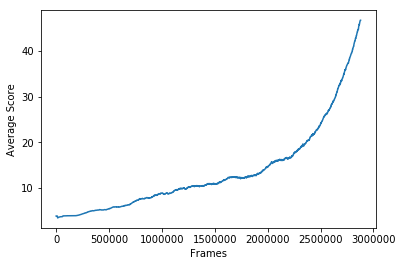

In [26]:
f = open('final_log_file.txt', 'r')
line = f.read().strip().split('\n')
values = []
for ln in line:
    segs = ln.split('/')
    values.append(float(segs[-1].split(' ')[-1]))
plt.figure()
plt.plot(np.arange(len(values))*1000, values)
plt.xlabel('Frames')
plt.ylabel('Average Score')
plt.show()

In [27]:
#net = torch.load('saving_nets/' + GAME + '-dqn' + str(2876000) + '.txt')
net = torch.load('final_model.mdl')
FINAL_EPSILON = 0.0001 # epsilon的最终值
BATCH = 32 # 每一个批次的数据记录条数
FRAME_PER_ACTION = 1 # 每间隔多少时间完成一次有效动作的输出

In [28]:
# 开始在内存／GPU上定义一个网络
use_cuda = torch.cuda.is_available() #检测本台机器中是否有GPU

# 如果有GPU，就把神经网络全部搬到GPU内存中做运算
net = net.cuda() if use_cuda else net

# 开启一个游戏进程，开始与游戏引擎通话
game_state = GameState()

# 状态打印log记录位置
#a_file = open("logs_" + GAME + "/readout.txt", 'w')
#h_file = open("logs_" + GAME + "/hidden.txt", 'w')

# 将游戏设置为初始状态，并获得一个80*80的游戏湖面
do_nothing = np.zeros(ACTIONS)
do_nothing[0] = 1
x_t, r_0, terminal = game_state.frame_step(do_nothing)
x_t = cv2.cvtColor(cv2.resize(x_t, (80, 80)), cv2.COLOR_BGR2GRAY)
ret, x_t = cv2.threshold(x_t,1,255,cv2.THRESH_BINARY)

# 将初始的游戏画面叠加成4张作为神经网络的初始输入状态s_t
s_t = np.stack((x_t, x_t, x_t, x_t), axis=0)

# 设置初始的epsilon（采取随机行动的概率），并准备训练
epsilon = FINAL_EPSILON
t = 0# 记录每轮平均得分的容器
scores = []
all_turn_scores = []

fig = plt.figure()
axe = fig.add_subplot(111)
dat = np.zeros((10, 10))
img = axe.imshow(dat)
while "flappy bird" != "angry bird":
    # 开始游戏循环
    ######################################################
    ##########首先，按照贪婪策略选择一个行动 ##################
    s = torch.from_numpy(s_t).type(torch.FloatTensor).requires_grad_(False)
    s = s.cuda() if use_cuda else s
    s = s.view(-1, s.size()[0], s.size()[1], s.size()[2])
    # 获取当前时刻的游戏画面，输入到神经网络中
    readout, h_fc1 = net(s)
    # 神经网络产生的输出为readout：选择每一个行动的预期Q值
    readout = readout.cpu() if use_cuda else readout
    # readout为一个二维向量，分别对应每一个动作的预期Q值
    readout_t = readout.data.numpy()[0]

    # 按照epsilon贪婪策略产生小鸟的行动，即以epsilon的概率随机输出行动或者以
    # 1-epsilon的概率按照预期输出最大的Q值给出行动
    a_t = np.zeros([ACTIONS])
    action_index = 0
    if t % FRAME_PER_ACTION == 0:
        # 如果当前帧可以行动，则
        if random.random() <= epsilon:
            # 产生随机行动
            #print("----------Random Action----------")
            action_index = random.randrange(ACTIONS)
        else:
            # 选择神经网络判断的预期Q最大的行动
            action_index = np.argmax(readout_t)
        a_t[action_index] = 1
    else:
        a_t[0] = 1 # do nothing
    ######################################################################### 
    ##########其次，将选择好的行动输入给游戏引擎，并得到下一帧的状态 ################### 
    x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
    # 返回的x_t1_colored为游戏画面，r_t为本轮的得分，terminal为游戏在本轮是否已经结束
    
    # 记录一下每一步的成绩
    scores.append(r_t)
    if terminal:
        # 当游戏结束的时候，计算一下本轮的总成绩，并将总成绩存储到all_turn_scores中
        all_turn_scores.append(sum(scores))
        scores = []
    
    # 对游戏的原始画面做相应的处理，从而变成一张80*80的，朴素的（无背景画面）的图
    x_t1 = cv2.cvtColor(cv2.resize(x_t1_colored, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, x_t1 = cv2.threshold(x_t1, 1, 255, cv2.THRESH_BINARY)
    x_t1 = np.reshape(x_t1, (1, 80, 80))
    # 将当前帧的画面和前三帧的画面合并起来作为Agent获得的环境反馈结果
    s_t1 = np.append(x_t1, s_t[:3, :, :], axis=0)
    s_t = s_t1
    t += 1
    clear_output(wait = True)
    
    image = np.transpose(x_t1_colored, (1, 0, 2))
    img.set_data(image)
    img.autoscale()
    display(fig)

KeyboardInterrupt: 